# Employee Attrition Prediction

---

A stable workforce is vital for organisation's success, leading to increased productivity, cost effectiveness and retention of institutional knowledge. This project aims to predict employee attrition using Random Survival Forest (RSF) and Cox Proportional Hazard (CoxPH) models, identify factors that influences attrition, and propose intervention strategies.

### Data Source

Our dataset is sourced from [IBM HR analytics synthetic data](https://github.com/IBM/employee-attrition-aif360/), made available under [Open Database License](https://opendatacommons.org/licenses/odbl/1.0/) and [Database Content License](https://opendatacommons.org/licenses/dbcl/1.0/).

### Analysis Tool

We will be using R for our data analysis.

---

## Performing Data Wrangling

After importing the dataset, we first skim the data and check for data types, ranges, duplicates and empty values.

In [1]:
# Importing data
rm(list = ls())
hr <- read.csv("hr_data.csv")

# First few rows.
head(hr)
# Number of duplicated rows
nrow(hr[duplicated(hr), ])
# Number of empty values
sum(is.na(hr))
# All column's range and type
summary(hr)
sapply(hr, function(x) {
  unique_vals <- unique(x)
  if (length(unique_vals) <= 10) return(unique_vals)
  return(c(unique_vals[1:10], "etc"))
})

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,⋯,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,⋯,1,80,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,⋯,4,80,1,10,3,3,10,7,1,7
3,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,⋯,2,80,0,7,3,3,0,0,0,0
4,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,⋯,3,80,0,8,3,3,8,7,3,0
5,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,⋯,4,80,1,6,3,3,2,2,2,2
6,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,⋯,3,80,0,8,2,2,7,7,3,6


[1] 0

[1] 0

      Age         Attrition         BusinessTravel       DailyRate     
 Min.   :18.00   Length:1470        Length:1470        Min.   : 102.0  
 1st Qu.:30.00   Class :character   Class :character   1st Qu.: 465.0  
 Median :36.00   Mode  :character   Mode  :character   Median : 802.0  
 Mean   :36.92                                         Mean   : 802.5  
 3rd Qu.:43.00                                         3rd Qu.:1157.0  
 Max.   :60.00                                         Max.   :1499.0  
  Department        DistanceFromHome   Education     EducationField    
 Length:1470        Min.   : 1.000   Min.   :1.000   Length:1470       
 Class :character   1st Qu.: 2.000   1st Qu.:2.000   Class :character  
 Mode  :character   Median : 7.000   Median :3.000   Mode  :character  
                    Mean   : 9.193   Mean   :2.913                     
                    3rd Qu.:14.000   3rd Qu.:4.000                     
                    Max.   :29.000   Max.   :5.000              

$Age
 [1] "41"  "49"  "37"  "33"  "27"  "32"  "59"  "30"  "38"  "36"  "etc"

$Attrition
[1] "Yes" "No" 

$BusinessTravel
[1] "Travel_Rarely"     "Travel_Frequently" "Non-Travel"       

$DailyRate
 [1] "1102" "279"  "1373" "1392" "591"  "1005" "1324" "1358" "216"  "1299"
[11] "etc" 

$Department
[1] "Sales"                  "Research & Development" "Human Resources"       

$DistanceFromHome
 [1] "1"   "8"   "2"   "3"   "24"  "23"  "27"  "16"  "15"  "26"  "etc"

$Education
[1] 2 1 4 3 5

$EducationField
[1] "Life Sciences"    "Other"            "Medical"          "Marketing"       
[5] "Technical Degree" "Human Resources" 

$EmployeeCount
[1] 1

$EmployeeNumber
 [1] "1"   "2"   "4"   "5"   "7"   "8"   "10"  "11"  "12"  "13"  "etc"

$EnvironmentSatisfaction
[1] 2 3 4 1

$Gender
[1] "Female" "Male"  

$HourlyRate
 [1] "94"  "61"  "92"  "56"  "40"  "79"  "81"  "67"  "44"  "84"  "etc"

$JobInvolvement
[1] 3 2 4 1

$JobLevel
[1] 2 1 3 4 5

$JobRole
[1] "Sales Executive"           "Research Scientist"       
[3] "Laboratory Technician"     "Manufacturing Director"   
[5] "Healthcare Representative" "Manager"                  
[7] "Sales Representative"      "Research Director"        
[9] "Human Resources"          

$JobSatisfaction
[1] 4 2 3 1

$MaritalStatus
[1] "Single"   "Married"  "Divorced"

$MonthlyIncome
 [1] "5993" "5130" "2090" "2909" "3468" "3068" "2670" "2693" "9526" "5237"
[11] "etc" 

$MonthlyRate
 [1] "19479" "24907" "2396"  "23159" "16632" "11864" "9964"  "13335" "8787" 
[10] "16577" "etc"  

$NumCompaniesWorked
 [1] 8 1 6 9 0 4 5 2 7 3

$Over18
[1] "Y"

$OverTime
[1] "Yes" "No" 

$PercentSalaryHike
 [1] "11"  "23"  "15"  "12"  "13"  "20"  "22"  "21"  "17"  "14"  "etc"

$PerformanceRating
[1] 3 4

$RelationshipSatisfaction
[1] 1 4 2 3

$StandardHours
[1] 80

$StockOptionLevel
[1] 0 1 3 2

$TotalWorkingYears
 [1] "8"   "10"  "7"   "6"   "12"  "1"   "17"  "5"   "3"   "31"  "etc"

$TrainingTimesLastYear
[1] 0 3 2 5 1 4 6

$WorkLifeBalance
[1] 1 3 2 4

$YearsAtCompany
 [1] "6"   "10"  "0"   "8"   "2"   "7"   "1"   "9"   "5"   "4"   "etc"

$YearsInCurrentRole
 [1] "4"   "7"   "0"   "2"   "5"   "9"   "8"   "3"   "6"   "13"  "etc"

$YearsSinceLastPromotion
 [1] "0"   "1"   "3"   "2"   "7"   "4"   "8"   "6"   "5"   "15"  "etc"

$YearsWithCurrManager
 [1] "5"   "7"   "0"   "2"   "6"   "8"   "3"   "11"  "17"  "1"   "etc"

There are issues that we can solve by transforming our data:

1. Some unnecessary variables for analysis, such as the one reflecting unique identification (that is, `EmployeeNumber`) and the single-valued ones (such as `EmployeeCount`).

2. All string variables are categorical, with some variables specifically Boolean.

We will filter `EmployeeNumber` and single-valued variables via column name list to retain original dataset, and adjust the format of categorical variables. For the purpose of clarifying survival status in R's package, we convert variable `Attrition` into Boolean type.

A separate exploration conducted by Project Creator indicates possible cross-column consistency issues, particularly from time period columns (`Age`, `TotalWorkingYears`, `Years...`) and income columns (`DailyRate`, `HourlyRate`, `MonthlyIncome`, `MonthlyRate`). These may have been accidentally introduced during the creation process of our synthetic data, and with the lack of complete data column descriptions, we are skipping cleaning this aspect for now. We are also making a mental note that time period columns may have a zero value, perhaps from a round-down of "six months or less".

## Performing Additional Cleaning

In [2]:
# Filter columns
cols <- names(hr)
cols <- cols[cols != "EmployeeNumber"]
single_value_cols <- names(hr)[sapply(hr, function (col) length(unique(col)) == 1)]
cols <- cols[!(cols %in% single_value_cols)]

# Convert column data types
cat_cols <- c("BusinessTravel", "Department", "Gender", "EducationField", "JobRole", "MaritalStatus")
hr[cat_cols] <- lapply(hr[cat_cols], factor)
bool_cols <- c("Attrition", "Over18", "OverTime")
hr[bool_cols] <- lapply(hr[bool_cols], function (col) ifelse(col %in% c("Yes", "Y"), TRUE, FALSE))

head(hr[cols])

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,⋯,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<lgl>,<fct>,<int>,<fct>,<int>,<int>,<fct>,<int>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,TRUE,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,⋯,3,1,0,8,0,1,6,4,0,5
2,49,FALSE,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,⋯,4,4,1,10,3,3,10,7,1,7
3,37,TRUE,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,⋯,3,2,0,7,3,3,0,0,0,0
4,33,FALSE,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,⋯,3,3,0,8,3,3,8,7,3,0
5,27,FALSE,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,⋯,3,4,1,6,3,3,2,2,2,2
6,32,FALSE,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,4,Male,⋯,3,3,0,8,2,2,7,7,3,6


---

## Developing Initial Models

We develop Random Survival Forest and Cox Proportional Hazard models, available from R's library `randomForestSRC` and `Survival`. By [some comparative research on high-dimensional survival data](https://www.nature.com/articles/s41598-020-77220-w), RSF with variable importance feature selection, as well as CoxPH with univariate Cox feature selection, seem to perform pretty well on empirical data.

Initially we will use all our variables as the features, sparing `YearsAtCompanies` as the survival time variable and `Attrition` as status variable. The number of trees used in RSF is on the lower scale (100) for faster process. Feature selection also allows us to understand what contribute to employee's attrition.

To measure model accuracy, we use Prediction Error Curve (PEC, i.e. integrated Brier score). As we can see below, the PEC graph shows that our model has at least $92\%$ accuracy ($8\%$ error) in predicting employee retention/attrition probability within the span of 10 years.

[1] "Average variable importance:"
    YearsWithCurrManager                 OverTime       YearsInCurrentRole 
            0.0573353268             0.0559978999             0.0394571038 
                JobLevel        TotalWorkingYears                      Age 
            0.0248574373             0.0245187615             0.0194049404 
      NumCompaniesWorked            MonthlyIncome         StockOptionLevel 
            0.0174346372             0.0152975194             0.0092495903 
                 JobRole          JobSatisfaction         DistanceFromHome 
            0.0077333686             0.0060964291             0.0057254179 
 EnvironmentSatisfaction          WorkLifeBalance            MaritalStatus 
            0.0056090568             0.0051712229             0.0040035966 
          JobInvolvement    TrainingTimesLastYear               Department 
            0.0037407563             0.0029242578             0.0022438329 
          EducationField        PercentSalaryHike  Ye

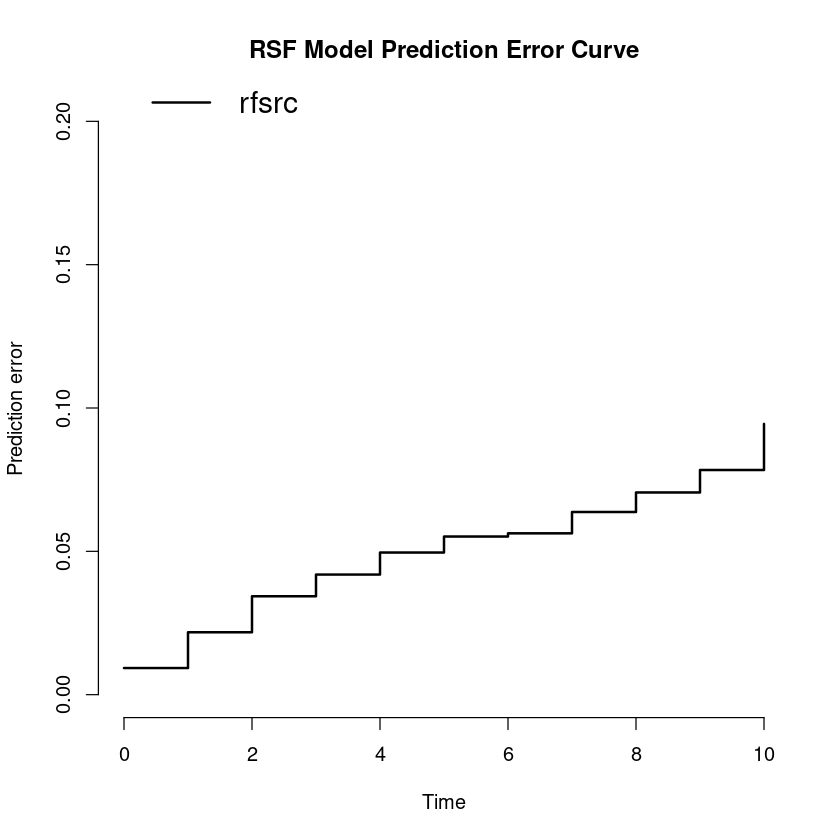

In [3]:
suppressMessages(library(randomForestSRC))
library(survival)
suppressMessages(library(pec))
library(ggplot2)
suppressMessages(library(viridis))

# ------- RSF model
rsf_model <- function (df) {
  model <- rfsrc(Surv(YearsAtCompany, Attrition) ~ ., data = df, ntree = 100)
  return(model)
}

# Accuracy plot
plot_pec <- function(df, model) {
  suppressMessages(pred_error <- pec(model, data = df, formula = Surv(YearsAtCompany, Attrition) ~ .,
                    splitMethod = "cv10", cens.model = "marginal", reference = FALSE))
  plot(pred_error, xlim = c(0, 10), ylim = c(0, 0.2))
  title("RSF Model Prediction Error Curve")
}

# Cross-validation functions
train_test_generate <- function (df, proportion = 0.7) {
  size <- round(proportion * nrow(df))
  idx <- sample(seq_len(nrow(df)), size = size, replace = FALSE)
  return(list("train" = df[idx, ], "test" = df[-idx, ]))
}
cross_val <- function (df, model_f, metric_f, k = 20) {
  for (fold in 1:k) {
    separate <- train_test_generate(df)
    train <- separate$train
    test <- separate$test
    model <- model_f(train)
    if (!(exists("metric_tot"))) {
      metric_tot <- metric_f(test, model)
    } else {
      metric_tot <- metric_tot + metric_f(test, model)
    }
  }
  metric_avg <- metric_tot/length(metric_tot)
  return(metric_avg[order(abs(metric_avg), decreasing = TRUE)])
}

# Importance function
rsf_importance <- function (df, model) {
  importance <- predict(model, df, importance = TRUE)$importance
  return(importance)
}
print_rsf_var_rank <- function (df) {
  print("Average variable importance:")
  print(cross_val(df, rsf_model, rsf_importance))
}


# First iteration
hr1 <- hr[cols]
model_v1 <- rsf_model(hr1)
plot_pec(hr1, model_v1)
print_rsf_var_rank(hr1)

From the importance table, time-dependent variables such as `YearsWithCurrManager`, `YearsInCurrentRole`, `TotalWorkingYears` and `Age`, dominate the model. This might indicate that they are highly correlated with our survival-time variable `YearsAtCompany`, encoding not only redundancy for RSF model but also multicollinearity which breaks the requirements for CoxPH model.

From the correlation map, this indeed happen, albeit lesser with `Age`:

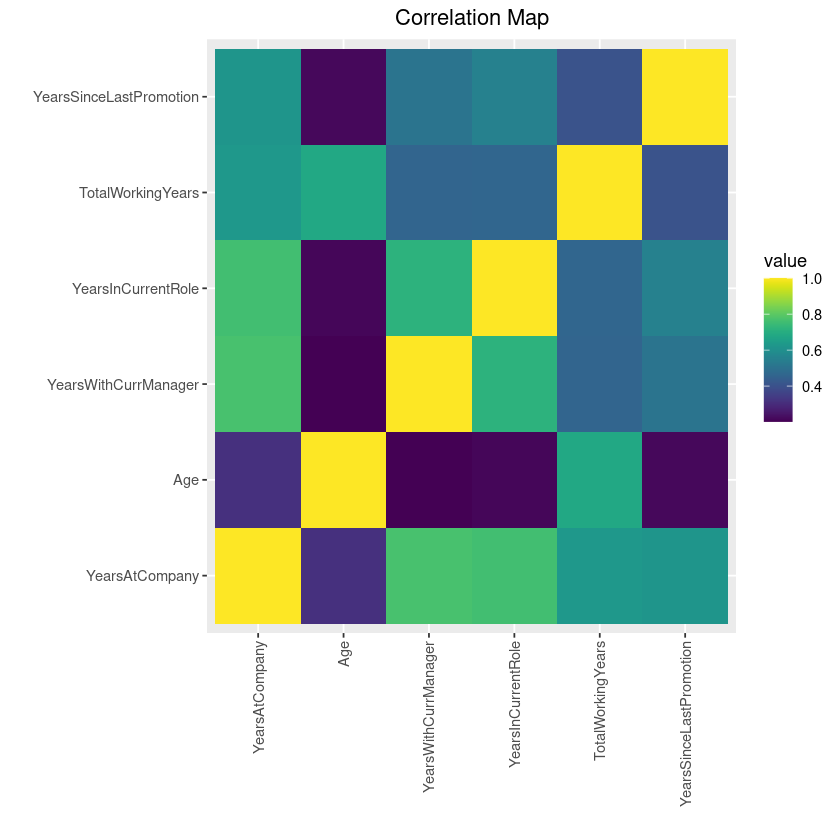

In [4]:
# Correlation
library(reshape2)

plot_correlation <- function (df) {
  # Only numerical (unless categories can be continuously extended)
  cor_matrix <- cor(df)
  ggplot(data = melt(cor_matrix), aes(x = Var1, y = Var2, fill = value)) +
    geom_tile() + scale_fill_viridis() +
    xlab("") + ylab("") + ggtitle("Correlation Map") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
         plot.title = element_text(hjust = 0.5))
}

time_dependent_cols <- c("Age", "YearsWithCurrManager", "YearsInCurrentRole",
                         "TotalWorkingYears", "YearsSinceLastPromotion")
plot_correlation(hr[c("YearsAtCompany", time_dependent_cols)])

We can extract `YearsBeforeWorking` which is time-invariant. Now we redo the model:

In [5]:
hr["YearsBeforeWorking"] <- hr["Age"] - hr["TotalWorkingYears"]
cols <- c(cols[!(cols %in% time_dependent_cols)], "YearsBeforeWorking")
hr1 <- hr[cols]
print_rsf_var_rank(hr1)

[1] "Average variable importance:"
                JobLevel                 OverTime            MonthlyIncome 
            1.019721e-01             9.755290e-02             7.180143e-02 
        StockOptionLevel                  JobRole       NumCompaniesWorked 
            2.080839e-02             2.033051e-02             1.950978e-02 
 EnvironmentSatisfaction       YearsBeforeWorking            MaritalStatus 
            1.764807e-02             1.156703e-02             1.036971e-02 
        DistanceFromHome          WorkLifeBalance           JobInvolvement 
            8.916368e-03             7.785971e-03             7.638008e-03 
         JobSatisfaction           BusinessTravel               Department 
            6.744776e-03             4.744032e-03             4.666082e-03 
   TrainingTimesLastYear           EducationField RelationshipSatisfaction 
            4.446409e-03             4.396371e-03             4.056090e-03 
               Education              MonthlyRate    

We start our Cox Hazard model, with Schoenfeld residuals to check our model's assumption of proportional hazard. Since there are many features in the beginning, this will be in the latter step.

In [11]:
# ------ CoxPH model
coxph_model <- function (df) {
  options(warn = -1) 
  model <- coxph(data = df, formula = Surv(YearsAtCompany, Attrition) ~ .)
  options(warn = 0)
  return(model)
}
plot_schoenfeld <- function(df, col_name) {
  res <- residuals(coxph_model(df), type = "schoenfeld")
  plot(x = df["YearsAtCompany"], y = res[col_name]) 
}
coxph_score <- function (df, model) {
  return(summary(model)$coefficients[, "z"]) # the test data is indeed not used
}
coxph_slope <- function (df, model) {
  return(summary(model)$coefficients[, "coef"])
}
print_coxph_var_rank <- function (df) {
  print("Average univariate Cox score:")
  print(cross_val(df, coxph_model, coxph_score))
}

print_coxph_var_rank(hr1)

[1] "Average univariate Cox score:"
                    OverTimeTRUE               NumCompaniesWorked 
                     4.192441169                      3.014972401 
                  JobInvolvement                 DistanceFromHome 
                    -2.246720401                      2.010994006 
                 JobSatisfaction  BusinessTravelTravel_Frequently 
                    -1.972476867                      1.808040200 
                        JobLevel            TrainingTimesLastYear 
                    -1.738796600                     -1.593183347 
         EnvironmentSatisfaction              MaritalStatusSingle 
                    -1.349869271                      1.316034660 
        RelationshipSatisfaction                       GenderMale 
                    -1.243061785                      1.210597060 
     BusinessTravelTravel_Rarely                  WorkLifeBalance 
                     1.045709128                     -1.013630528 
                     Month

## Feature Selection

From the two models, it is suggestive that `OverTime`, `NumCompaniesWorked`, `JobLevel` and `DistanceFromHome` induce attrition.

The variable `NumCompaniesWorked` can confuse the effect of job-hopping and one of longer work experience. However, since it does not seem to correlate much with `TotalWorkingYears` (not shown), we can somewhat assume that it is an indicator of job-hopping.

The `JobLevel` might indicate lack of career progression or financial compensation (due to high link to `MonthlySalary`).s

Meanwhile, `MonthlyIncome` and `StockOptionLevel` and `JobRole` appear important in RFS but not in CoxPH. The reverse happen for the significance of `JobInvolvement` and `JobSatisfaction`.

Plotting correlation map again with currently discussed covariates (sparing categorical variable `JobRole`), it seems that our features are independent except `JobLevel` and `MonthlyIncome`. Since `JobLevel` performs well in both models, we throw `MonthlyIncome` from our consideration.

In [ ]:
focus_cols <- c("Attrition", "YearsAtCompany", "OverTime", "NumCompaniesWorked", "JobLevel", "DistanceFromHome",
                "MonthlyIncome", "StockOptionLevel", "JobInvolvement", "JobSatisfaction")
plot_correlation(hr[focus_cols])

### Segmenting Attrition Rate

Now, we examine aggregated historical attrition rates for the categorical features `JobRole`

In [ ]:
suppressMessages(library(dplyr))

aggregated_attrition <- function (df, col) {
    options(warn = -1) # Suppress warnings
    
    # Best for categorical (unless numerical int range is small)
    result <- df[, c("Attrition", col)] %>%
      group_by_(col) %>%
      summarize(
        AttritionCount = sum(Attrition),
        TotalEmployees = n(),
        AttritionRate = AttritionCount/TotalEmployees
    )
    
    options(warn = 0) # Reactivate warnings
    return(result)
}

aggregated_attrition(hr, "JobRole")

Among job positions, managerial positions and Healthcare Representation have around $5\%$ attrition rate, while general positions sit at about $15-25\%$. [A simple online search](https://www.statista.com/statistics/934377/professional-services-worldwide-employee-attrition-by-region/) shows an average of $10-18\%$ global churn rate in 2022, so this company's number is comparatively a pretty high one. Sales reps roles are particularly prone to attrition (a whopping $40\%$) while also having a small number of employees. This is therefore an employee group that we need to focus on for mitigating their leaving.

We can group `JobRole` into five generalised group: leadership, research area, business, and a single group of healthcare and sales representatives.

## Developing Next Models

We redo our models with newer 8 features. The `Sales Representative` job role appears prominent in CoxPH model.

In [33]:
# Second iteration model
cols <- c("Attrition", "YearsAtCompany", "OverTime", "NumCompaniesWorked", "JobLevel", "DistanceFromHome",
          "StockOptionLevel", "JobRole", "JobInvolvement", "JobSatisfaction")
hr2 <- hr[cols]
print_rsf_var_rank(hr2)
print_coxph_var_rank(hr2)

'
plot_schoenfeld <- function(df, col_name) {
  res <- as.data.frame(residuals(coxph_model(df), type = "schoenfeld"))
    str(res); str(col_name)
  plot(x = df["YearsAtCompany"], y = res[col_name, ]) 
}
# Check proportional hazard assumptions
for (col in names(coxph_score(hr2, coxph_model(hr2)))) {
    if (!(col %in% c("Attrition", "YearsAtCompany"))) plot_schoenfeld(hr, col)
}'

[1] "Average variable importance:"
          JobLevel           OverTime   StockOptionLevel            JobRole 
        0.67701371         0.32813091         0.18124836         0.14001891 
NumCompaniesWorked   DistanceFromHome     JobInvolvement    JobSatisfaction 
        0.07614403         0.05422131         0.04867108         0.01945830 
[1] "Average univariate Cox score:"
                 OverTimeTRUE            NumCompaniesWorked 
                 10.563731055                   7.359236270 
                     JobLevel              StockOptionLevel 
                 -7.040337670                  -5.821823931 
               JobInvolvement              DistanceFromHome 
                 -5.392290133                   4.771626879 
  JobRoleSales Representative               JobSatisfaction 
                  4.640853625                  -3.485746768 
       JobRoleSales Executive        JobRoleHuman Resources 
                  3.062457917                   2.396698057 
 JobRoleLab

[1] "\nplot_schoenfeld <- function(df, col_name) {\n  res <- as.data.frame(residuals(coxph_model(df), type = \"schoenfeld\"))\n    str(res); str(col_name)\n  plot(x = df[\"YearsAtCompany\"], y = res[col_name, ]) \n}\n# Check proportional hazard assumptions\nfor (col in names(coxph_score(hr2, coxph_model(hr2)))) {\n    if (!(col %in% c(\"Attrition\", \"YearsAtCompany\"))) plot_schoenfeld(hr, col)\n}"

---

## Predicting Employee Attrition Result

We create the prediction of attrition probability of our employees in the next five years, adding details such as median and mean.

We also identify 50 individuals at risk of leaving their jobs, ignoring the ones with positive attrition already. The assessment this time is rather based on hazard function rather than survival probability.

In [ ]:
# Generating anti-survival probability for five years
rsf_attrition_probability <- function (df) {
  return(1 - predict(rsf_model(df), df)$survival)
}
pred_attr_probs <- rsf_attrition_probability(hr)
years = 5
ap_cols <- sapply(0:years, function(i) paste0("AttritionProbYear", i))
hr[ap_cols] <- pred_attr_probs[, (0:years) + 1]

# Rough estimate of median and mean quitting time interval
hr["MedianAttritionTime"] <- apply(pred_attr_probs, 1, function (F) {
  q = 0.5
  n <- sum(F <= q)
  if (n == 0) { n }
  else if (n == length(F) || F[n] == F[n+1]) { n-1 }
  else{ n-1 + (q - F[n])/(F[n+1] - F[n]) }
})
hr["ExpectedAttritionTime"] <- apply(pred_attr_probs, 1, function (F) {
  lim <- length(F) - 1
  F_smooth <- splinefun(x = 0:lim, y = F, method = "fmm")
  lim - integrate(F_smooth, 0, lim)$value
})
                  
preview_cols <- c("EmployeeNumber", cols, ap_cols, "MedianAttritionTime", "ExpectedAttritionTime")
head(hr[preview_cols])

In [ ]:
# Top employees at risk
cutoff = 50
rsf_high_risk_indiv_idx <- function (df) {
  df$HazardScore <- predict(rsf_model(df), df)$predicted
  df <- df[df["Attrition"] == FALSE, ]
  return(row.names(df)[order(df$HazardScore, decreasing = TRUE)[1:cutoff]])
}
hriidx <- rsf_high_risk_indiv_idx(hr)
hr[hriidx, preview_cols]

# Visualisation
plot(1, type = "n", xlim = c(0, years), ylim = c(0, 1), xlab = "Year", ylab = "Probability")
title(paste0("Top ", cutoff, " High-Risk Employee Attrition Trajectory"))
hrindv <- hr[hriidx, ap_cols]
for (i in 1:cutoff) {
  lines(0:years, hrindv[i, ], col = i, type = "l")
}
#legend("topright", legend = hr[hriidx, "EmployeeNumber"], col = 1:cutoff, lty = 1, title = "Employee Num")

## User Interface

A bare interface is formed from the code cell, so that our target stakeholders (such as H.R.) can input employee number and get the predictive output.

In [ ]:
# Bare UI
input <- readline("Enter Employee Number (or 'q' to quit): ")

if (input == "q") {
  break
}
employee_number <- as.integer(input)
if (!(employee_number %in% hr$EmployeeNumber)) {
  cat("Invalid employee number. Please try again.")
  next
}

employee <- hr[which(hr$EmployeeNumber == employee_number), ]
cat(paste0("Employee no.: ", employee_number, "\n"))
cat(paste0("Attrition probability after ... \n"))
lapply(0:years, function(i) cat(paste0(i, " years: ", employee[paste0("AttritionProbYear", i)], "\n")))

---

## Recommended strategies


### Overtime Management

Excessive overtime can lead to burnout among employees. Implement strategies to manage and reduce overtime, such as workload distribution, hiring additional staff, or arranging flexible work arrangements.

### Salary Compensation, Career Opportunities and Benefits

Focus on retention by providing fair financial compensation and career progression, empowerment programs and stock option incentives. This can reduce job-hopping behavior.

### Remote/Hybrid Work

Explore flexibility in place of work to reduce commuting stress for employees living far from office.

### Retention Programs for Sales Reps

Our sales representatives are more prone to attrition. Implement retention programs specific to this group, such as performance-based incentives, career development paths, and mentorship programs.